# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [5]:
feature_cols = X_train.columns[X_train.columns.str.startswith('C') == False]
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [6]:
import numpy as np
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)


def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    # booleano para calcular izquierdo y derecho.
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    # numero que hay en cada uno 
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    # gini del nodo izquierdo y gini derecho
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation, guardar la información en cada nodo.split, numero de muestra y probabilidad
    # ajuste  Laplace para que no me de infinito.
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
   
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct) 
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=0)
    # guardo como nodo terminal, aplicar el best split.
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition, partir del lado x completo
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [7]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [8]:
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': -1,
    'n_samples': 98,
    'gain': 0},
   'sr': {'y_pred': 0,
    'y_prob': 0.46757679180887374,
    'level': 3,
    'split': -1,
    'n_samples': 291,
    'gain': 0}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8743054224947308,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 5217,
   'gain': 0.014933378976312917,
   'sl': {'y_pred': 1,
    'y_prob': 0.7348484848484849,
    'level': 3,
    'split': -1,
    'n_samples': 1450,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_prob': 0.92783

In [9]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [10]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 

y_pred_=tree_predict(X_test, tree)

print("F1-Score: \n",f1_score(y_test,y_pred_))
print("Accuracy: \n", accuracy_score(y_test,y_pred_))

F1-Score: 
 0.882798833819242
Accuracy: 
 0.8610599078341014


In [11]:
y_pred_=tree_predict(X_test, tree)
y_pred_

array([0., 1., 1., ..., 1., 1., 0.])

In [12]:
tree_predict(X_test, tree)

array([0., 1., 1., ..., 1., 1., 0.])

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [13]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [14]:
# DataFrame for storing predicted price from each tree
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train= X_train.iloc[sample,:]
    y_train= y_train.iloc[sample]
    tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred[i] = tree_predict(X_test, tree)

In [15]:
y_pred

,0,1,2,3,4,5,6,7,8,9
332784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205915,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250833,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
126784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Evaluate each model
from sklearn.metrics import mean_squared_error

for i in range(n_B):
    print("Acuracy Score:")
    print(i, accuracy_score(y_pred[i], y_test))

Acuracy Score:
0 0.8610599078341014
Acuracy Score:
1 0.8610599078341014
Acuracy Score:
2 0.8610599078341014
Acuracy Score:
3 0.8610599078341014
Acuracy Score:
4 0.8610599078341014
Acuracy Score:
5 0.8610599078341014
Acuracy Score:
6 0.8610599078341014
Acuracy Score:
7 0.8610599078341014
Acuracy Score:
8 0.8610599078341014
Acuracy Score:
9 0.8610599078341014


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [17]:
def tree_grow_max(X, y,max_features=None, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation, guardar la información en cada nodo.split, numero de muestra y probabilidad
    # ajuste  Laplace para que no me de infinito.
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    X_subset=X.sample(n=max_features,axis=1)
    
    # Calculate the best split
    j, split, gain = best_split(X_subset, y, num_pct) 
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=0)
    # guardo como nodo terminal, aplicar el best split.
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition, partir del lado x completo
    filter_l = X_subset.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [18]:
tree_max = tree_grow_max(X_train, y_train,max_features=7, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [19]:
tree_max

{'y_pred': 1,
 'y_prob': 0.598161597821153,
 'level': 0,
 'split': [5, 50123.0],
 'n_samples': 8810,
 'gain': 0.22900209352934453,
 'sl': {'y_pred': 1,
  'y_prob': 0.8541852578975548,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5601,
  'gain': 0.026156726856012835,
  'sl': {'y_pred': 0,
   'y_prob': 0.35587188612099646,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 279,
   'gain': 0.07988240637298571,
   'sl': {'y_pred': 0,
    'y_prob': 0.08333333333333333,
    'level': 3,
    'split': -1,
    'n_samples': 94,
    'gain': 0},
   'sr': {'y_pred': 0,
    'y_prob': 0.49732620320855614,
    'level': 3,
    'split': -1,
    'n_samples': 185,
    'gain': 0}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8803531179564238,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 5322,
   'gain': 0.009160931850137943,
   'sl': {'y_pred': 1,
    'y_prob': 0.772,
    'level': 3,
    'split': -1,
    'n_samples': 1498,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_prob': 0.9226346053319

In [20]:
y_pred_max=tree_predict(X_test, tree_max)
y_pred_max

array([0., 1., 1., ..., 1., 1., 0.])

In [21]:
print("accuracy score:",accuracy_score(y_pred_max, y_test))

accuracy score: 0.8495391705069124


In [22]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

max_features = []

for feature in feature_range:
    tree_max = tree_grow_max(X_train, y_train, max_features=feature, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred_max = tree_predict(X_test, tree_max)
    
    max_features.append(accuracy_score(y_test, y_pred_max))
    
max_features_df = pd.DataFrame(max_features)
max_features_df.rename(columns = {0 : 'max_features'}, inplace=True)

Text(0, 0.5, 'Accuracy')

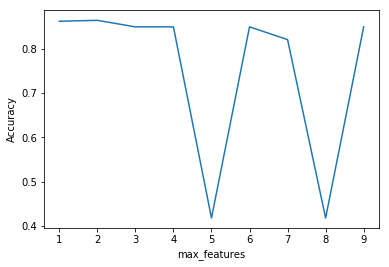

In [23]:
import matplotlib.pyplot as plt

plt.plot(feature_range, max_features)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [24]:
max_features_df.loc[max_features_df.max_features == max_features_df["max_features"].max()]

,max_features
1,0.864286


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [25]:
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [26]:
import math

y_pred_t = []

n_features = X_train.shape[1] 
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample, :]
    y_train = y_train.iloc[sample]
    tree_max = tree_grow_max(X_train, y_train, max_features=int(np.round(math.log(n_features))),
                       level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred_t.append(tree_predict(X_test, tree_max))

pd.DataFrame(y_pred_t).head()

,0,1,2,3,4,5,6,7,8,9,...,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0


In [27]:
y_pred = (pd.DataFrame(y_pred_t).sum() >= (n_B * 0.5 ) ).astype(np.int)
print("Accuracy Score:",accuracy_score(y_test, y_pred))

Accuracy Score: 0.8569124423963134


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [28]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:

import warnings
warnings.filterwarnings('ignore')

# max_depth=2 was best, so fit a tree using that parameter
clf = RandomForestClassifier(max_depth=None, random_state=666, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=666, verbose=0, warm_start=False)

In [30]:
from sklearn.metrics import f1_score,accuracy_score
y_pred_skl = clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_pred_skl, y_test))
print("F1 score:",f1_score(y_pred_skl, y_test))


Accuracy Score: 0.8269585253456221
F1 score: 0.8521362472927742


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [31]:
# build Rando Forest Classifier
# instantiate a DecisionTreeClassifier (with random_state=1)

import warnings
warnings.filterwarnings('ignore')

In [32]:
from sklearn.metrics import accuracy_score

max_depth_skl = []

for depth in range(1, 50):
    clf = RandomForestClassifier(max_depth=depth, random_state=123, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred_skl_max = clf.predict(X_test)
    
    max_depth_skl.append(accuracy_score(y_test, y_pred_skl_max))

max_depth_skl_df = pd.DataFrame(max_depth_skl)
max_depth_skl_df.rename(columns={0 : 'max_depth'}, inplace=True)

Text(0, 0.5, 'Accuracy')

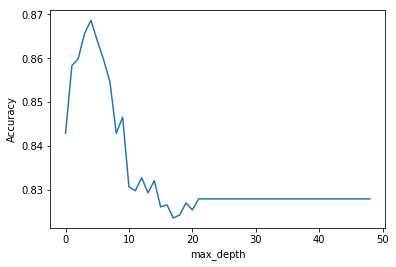

In [33]:
import matplotlib.pyplot as plt

plt.plot(max_depth_skl_df)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [34]:
max_depth_skl_df.loc[max_depth_skl_df.max_depth == max_depth_skl_df["max_depth"].max()]

,max_depth
4,0.868664


In [35]:

estimator_range = range(1, 100, 1)
n_estimators= []


# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=123, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    n_estimators.append(accuracy_score(y_test, y_pred))
    
n_estimators_df = pd.DataFrame(n_estimators)
n_estimators_df.rename(columns = {0 : 'n_estimators'}, inplace=True)

    

Text(0, 0.5, 'Accuracy')

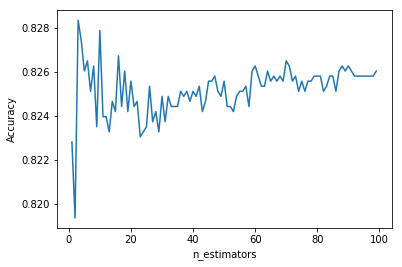

In [36]:
import matplotlib.pyplot as plt

plt.plot(estimator_range, n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [37]:
n_estimators_df.loc[n_estimators_df.n_estimators == n_estimators_df["n_estimators"].max()]

,n_estimators
2,0.828341


In [38]:
# list of values to try for max_features
feature_range_skl = range(1, len(feature_cols)+1)

max_features_skl_max_f = []

for feature_skl in feature_range_skl:
    clf_skl = RandomForestClassifier(max_features=feature_skl, random_state=123, n_jobs=-1)
    
    clf_skl.fit(X_train, y_train)
    y_pred_skl_max_f = clf_skl.predict(X_test)
    
    max_features_skl_max_f.append(accuracy_score(y_test, y_pred_skl_max_f ))
    
max_features_skl_max_f_df = pd.DataFrame(max_features_skl_max_f)
max_features_skl_max_f_df.rename(columns = {0 : 'max_features'}, inplace=True)


Text(0, 0.5, 'Accuracy')

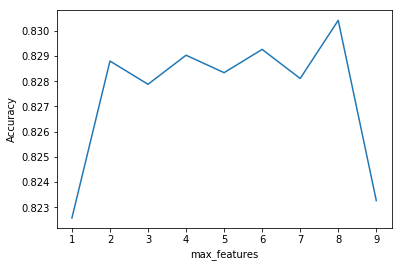

In [39]:
plt.plot(feature_range_skl, max_features_skl_max_f)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [40]:
max_features_skl_max_f_df.loc[max_features_skl_max_f_df.max_features == max_features_skl_max_f_df["max_features"].max()]

,max_features
7,0.830415


In [41]:
# max_features=7, max_depth=3 is best and n_estimators=30 is sufficiently large
clf = RandomForestClassifier(max_depth=4 ,n_estimators=2, max_features=7, random_state=123, n_jobs=-1)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [42]:
from sklearn.tree import export_graphviz
from sklearn import tree
import pydot


from sklearn.metrics import f1_score,accuracy_score
y_pred = clf.predict(X_test)
print("F1 score:",f1_score(y_pred, y_test))
print("accuracy_score:",accuracy_score(y_pred, y_test))

F1 score: 0.8773420900135213
accuracy_score: 0.8536866359447005


In [43]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
tree.export_graphviz(forest_clf.estimators_[0], out_file='tree_from_forest.dot')
(graph,) = pydot.graph_from_dot_file('tree_from_forest.dot')
graph.write_png('tree_from_forest.png')